# Algoritmos de ML para aprendizaje supervisado

En esta clase vamos a estudiar los métodos más comunes de aprendizaje supervisado, tanto en problemas de clasificación como de regresión. Dichos métodos son:

* kNN: Clasificación y regresión
* Regresión lineal simple, ridge, lasso y polinomial
* Clasificación por regresión logística
* Máquina de vector soporte (SVM)
* Árboles de decisión

Todas estas funciones están ya implementadas en la librería scikit-learn, así que aprenderemos a usarlas, y también a controlar alguno de los hiper-parámetros de los modelos.

A lo largo de toda la clase irán apareciendo conceptos básicos en el análisis de datos y Machine Learning, como son el problema del *sobreajuste (overfitting)*, las técnicas de *regularización (smoothing)* o la normalización de los datos. También abordaremos de manera práctica el problema de la selección de modelo, aunque dejaremos métodos más avanzados (grid_search) para más adelante.

#### Importamos algunas librerías que usaremos en la práctica

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
np.set_printoptions(precision=2)

## Datasets

Vamos a hacer un breve recorrido por los datasets que vamos a utilizar en la práctica. Algunos de ellos son sintéticos, y se han creado con el único propósito de testear algoritmos de regresión y clasificación enuna situación controlada. Otros son dataset "de juguete" con fines pedagógicos, pero también usaremos algunos datasets reales.



#### Dataset 1 - Un data set sencillo para regresión lineal simple

In [ ]:
from sklearn.datasets import make_regression
plt.figure()
plt.title('Datos para regresión lineal simple en una variable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

#### Dataset 2 - Dataset sintético para regresión más compleja con 7 variables predictoras

<IPython.core.display.Javascript object>


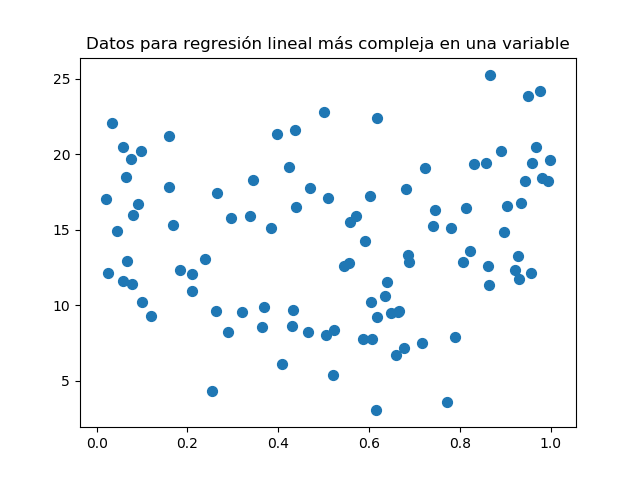

In [2]:
# dataset sintético para regresión más compleja
from sklearn.datasets import make_friedman1
plt.figure()
plt.title('Datos para regresión lineal más compleja en una variable')
X_F1, y_F1 = make_friedman1(n_samples = 100,
                           n_features = 7, random_state=0)

plt.scatter(X_F1[:, 2], y_F1, marker= 'o', s=50)
plt.show()

#### Dataset 3 - Dataset sintético para clasificación binaria

In [ ]:
# Dataset sintético para clasificación binaria
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])
plt.figure()
plt.title('Clasificación binaria con 2 variables predictoras')
X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,
                                n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y = 0.1,
                                class_sep = 0.5, random_state=0)
plt.scatter(X_C2[:, 0], X_C2[:, 1], c=y_C2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

#### Dataset 4 - Problema de clasificación binaria más complejo (clases no separables linealmente)

In [ ]:
from sklearn.datasets import make_blobs

X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2, centers = 8,
                       cluster_std = 1.3, random_state = 4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Clasificación binaria con clases no separables linealmente')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

#### Dataset 5 - Cancer de mama (Winsconsin) para diagnóstico

1) ID number 
2) Diagnosis (M = malignant, B = benign) 
3-32) 

Ten real-valued features are computed for each cell nucleus: 

a) radius (mean of distances from center to points on the perimeter) 
b) texture (standard deviation of gray-scale values) 
c) perimeter 
d) area 
e) smoothness (local variation in radius lengths) 
f) compactness (perimeter^2 / area - 1.0) 
g) concavity (severity of concave portions of the contour) 
h) concave points (number of concave portions of the contour) 
i) symmetry 
j) fractal dimension ("coastline approximation" - 1)

In [ ]:
# Dataset de cancer de mama para clasificación binaria
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

#### Dataset 6 -  Datos de crímenes por comunidades en USA

Este dataset contiene datos sobre el número de crímenes violentos per capita distribuidos por comunidades en Estados Unidos.
Se puede consultar el [dataset completo en UCI](http://archive.ics.uci.edu/ml/datasets/communities+and+crime)

In [ ]:
# Dataset sobre distribución de crimen por comunidades
from adspy_shared_utilities import load_crime_dataset
(X_crime, y_crime) = load_crime_dataset()
X_crime.head()

#### Dataset 7 -  Frutas (Clasificación en 4 clases con 4 variables predictoras)

In [ ]:
fruits = pd.read_table('../data/fruit_data_with_colors.txt')

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

## K-Nearest Neighbors

Vamos a empezar por estudiar el algoritmo k-NN y en particular la dependencia de la clasificación sobre el parámetro $k$.
En general, 

* valores de $k$ pequeños dan superficies de separación más rugosas. mejor predicción en train, pero posiblemente peor en test

* valores de $k$ altos dan superficies de separación más suaves. Eventualmente, si $k$ es muy alto se atribuye todo a la clase mayoritaria.

En cada problema particular, tendremos que averiguar cuál es el valor de $k$ que proporciona la mejor clasificación. Vamos a probar con uno de los datasets anteriores.



### Clasificación con k-NN en el dataset 1

In [ ]:
from adspy_shared_utilities import plot_two_class_knn

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2,
                                                   random_state=0)

plot_two_class_knn(X_train, y_train, 1, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 3, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 12, 'uniform', X_test, y_test)

También podemos utilizar (aunque no es muy habitual) el algoritmo de k-NN para problemas de regresión. En este caso, lo que haremos será promediar el valor de las features de los $k$ próximos vecinos para obtener el valor de la variable que se quiere predecir. Como resultado, se tendrá en 1 variables una curva constante a trozos

### Regresión con k-NN

Vamos a analizar cómo funciona la regresión con k-NN en los datos para la regresión simple del dataset 1.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1, random_state = 0)

knnreg = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)

print(knnreg.predict(X_test))
print('R-squared test score: {:.3f}'
     .format(knnreg.score(X_test, y_test)))

In [ ]:
fig, subaxes = plt.subplots(1, 2, figsize=(8,4))
X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_R1[0::5], y_R1[0::5], random_state = 0)

for thisaxis, K in zip(subaxes, [1, 3]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    thisaxis.set_xlim([-2.5, 0.75])
    thisaxis.plot(X_predict_input, y_predict_output, '^', markersize = 10,
                 label='Predicción', alpha=0.8)
    thisaxis.plot(X_train, y_train, 'o', label='Valor verdadero', alpha=0.8)
    thisaxis.set_xlabel('Variable input')
    thisaxis.set_ylabel('Variable target')
    thisaxis.set_title('Regresión KNN (K={})'.format(K))
    thisaxis.legend()
plt.tight_layout()

### Complejidad del modelo de regresión como función de K

In [ ]:
# plot k-NN regression on sample dataset for different values of K
fig, subaxes = plt.subplots(5, 1, figsize=(5,20))
X_predict_input = np.linspace(-3, 3, 500).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1,
                                                   random_state = 0)

for thisaxis, K in zip(subaxes, [1, 3, 7, 15, 55]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    train_score = knnreg.score(X_train, y_train)
    test_score = knnreg.score(X_test, y_test)
    thisaxis.plot(X_predict_input, y_predict_output)
    thisaxis.plot(X_train, y_train, 'o', alpha=0.9, label='Train')
    thisaxis.plot(X_test, y_test, '^', alpha=0.9, label='Test')
    thisaxis.set_xlabel('Variable input')
    thisaxis.set_ylabel('Variable target')
    thisaxis.set_title('Regresión KNN (K={})\n\
Train $R^2 = {:.3f}$,  Test $R^2 = {:.3f}$'
                      .format(K, train_score, test_score))
    thisaxis.legend()
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


## Modelos de regresión lineal

En esta sección vamos a ver los modelos de regresión lineal:

* regresión lineal simple (sin regularización)
* regresión lineal ridge (regularización L2)
* regresión lineal lasso (regularización L1)
* regresión polinómica

De paso, veremos como asoma el problema del *overfitting/underfitting*, y como lo podemos atajar con técnicas de regularización que impongan una penalización a la complejidad del modelo en la función de coste.

También veremos como la estandarización (en nuestro caso, escalado) de los datos conducen a una mejora en la eficiencia del ajuste.

### Regresión lineal
En el primer ejemplo sobre el dataset 1 de regresión simple, vemos como ajustar un modelo de LR con sklearn, utilizando la función `LinearRegression`. 

* El ajuste del modelo se hace (como de costubre) con el método `fit`, y toma los datos de entrenamiento.
* Los coeficientes (pesos) de la regresión se obtienen con el método `coef_` y `intercept_`.
* El coeficiente R2 se obtiene con el método `score` y toma como parámetros las X e y del conjunto a predecir (train o test)

In [ ]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('coef. del modelo lineal (w): {}'
     .format(linreg.coef_))
print('ordenada en el origen (b): {:.3f}'
     .format(linreg.intercept_))
print('métrica R2 (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('métrica R2 (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

### Regresión lineal: un gráfico de ejemplo

Aqui vemos el típico ejemplo de regresión lineal simple enun problema con una sola variable predictora.

In [ ]:
plt.figure(figsize=(5,4))
plt.scatter(X_R1, y_R1, marker= 'o', s=50, alpha=0.8)
plt.plot(X_R1, linreg.coef_ * X_R1 + linreg.intercept_, 'r-')
plt.title('Regresión lineal por mínimos cuadrados')
plt.xlabel('Variable input (x)')
plt.ylabel('Variable target (y)')
plt.show()

Sin embargo, podemos utilizar tantas variables predictoras como queramos, utilizando la misma sintaxis.

Vamos a ver por ejemplo el resultado de una regresión lineal para predecir el número de crímenes violentos per cápito usando la base de datos sobre crimen. Vemos que ahora el vector de pesos `linreg_coef_` que se obtiene como resultado del ajuste ya no es un único número, sino un array de las mismas dimensiones que el número de variables predictoras (en este caso, 88).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('Crime dataset')
print('linear model intercept: {}'
     .format(linreg.intercept_))
print('linear model coeff:\n{}'
     .format(linreg.coef_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))
X_train.shape[1]==len(linreg.coef_)

### Ridge regression

En la regresión ridge añadimos un término a la función de coste, que penaliza que los pesos tomen valores demasiado elevados, y por tanto favorece modelos más simples. La idea es evitar el overfitting. Para ello, en lugar de minimizar  el error cuadrático medio, vamos a minimizar la siguiente función:

$$ \sum_{i=1}^n \left( \hat y_i - b- \sum_{j=1}^k w_{ij} x_j \right)^2 + \lambda \sum_{j=1}^k w_j^2 =RSS +  \alpha \sum_{j=1}^k w_j^2 $$

El parámetro $\alpha$ es un parámetro de regularización (*smoothing parameter*) y su valor óptimo se ha de determinar por validación. Como valores extremos:

* Si $\alpha=0$ tenemos una regresión lineal simple, sin regularizar.
* Si $\alpha$ es muy grande, todos los pesos irán a cero, resultando en una predicción constante que sólo contiene la ordenada en el origen.

Vamos a aplicar una regressión ridge a los mosmos datos de dantes, utilizando el valor de $\alpha=20$. Para ello, en lugar de usar el método `LinearRegression` de scikit-learn, usamos la función `Ridge` (pero todo lo demás es igual).

In [ ]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

linridge = Ridge(alpha=20.0).fit(X_train, y_train)

print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Vemos que los resultados no son muy diferentes a los de la regresión lineal. ¿Qué está pasando ?
Al penalizar la suma de los pesos al cuadrado, no estamos teniendo en cuenta que las variables predictoras varía sobre diferentes escalas, por tanto el mismo valor de dos pesos puede tener efectos muy diferentes, y los estamos tratando a todos por igual en el término de penalización.

Solución: vamos a escalar los datos input para conseguir que todos ellos tengan la misma escala. Para ello utilizaremos la función `MinMaxScaler`que normalizará el valor más alto que tome cada variable a 1 y el más bajo a -1, escalando el resto de valores en el intervalo (-1,1).

**Atención:** Es muy importante aplicar el reescalado tomando sólo el valor máximo y mínimo sobre el conjunto de entrenamiento, y luego aplicar la misma transformación al conjunto de test. No podemos filtrar información del conjunto de test (en este caso, el valor mínimo y máximo de las variables) fuera de dicho conjunto pues estaríamos haciendo trampaa y obtendríamos resultados mejores de lo que serán en realidad.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
plt.figure(figsize=(5,4))
plt.title('Datos de la variable ' + X_train.columns[2] )
plt.scatter(range(len(X_train)),X_train.iloc[:,2])
plt.figure(figsize=(5,4))
plt.title('Datos de la variable ' + X_train.columns[2]+ ' reescalada')
plt.scatter(range(len(X_train_scaled)),X_train_scaled[:,2])
plt.show()

#### Ridge regression con normalización de variables

Ahora volvemos a hacer una regresión ridge con el mismo valor de $\alpha=20$, pero utilizando los datos escalados al integvalo (0,1).

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Vemos que el valor de $R^2$ sobre el conjunto de test ha pasado de 0.494 a 0.599, simplemente normallizando los datos !

#### Valores óptimos de $\alpha$

In [ ]:
print('Regresión Ridge: efecto del parámetro de regularización alpha\n')
for par_alpha in [0, 1, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = par_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(par_alpha, num_coeff_bigger, r2_train, r2_test))

Vemos por qué $\alpha$ es un parámetro de regularización: al incrementar su valor va disminuyendo la precisión del ajuste en el conjunto de entrenamiento. Sin embargo, en el conjunto de test se consiguen mejores resultados para valores de $\alpha$ intermedios. En este caso, el valor óptimo de $\alpha$ es de $\alpha=20$.

* Con $\alpha=0$ ó $\alpha=1$ estamos en un caso de *overfitting* (el modelo es demasiado complejo y no generaliza bien)
* Con $\alpha=1000$ estamos en un caso de *underfitting* (el modelo es demasiado simple y no ajusta bien)

### Lasso regression

La regresión lasso es similar en concepto a la anterior, y la única diferencia es que en el término de penalización se utilizar la norma L1 del vector de pesos en lugar de la norma euclídea L2. Es decir, la funcióna optimizar es en este caso:

$$ \sum_{i=1}^n \left( \hat y_i - b- \sum_{j=1}^k w_{ij} x_j \right)^2 + \alpha \sum_{j=1}^k \left|w_j\right| =RSS +  \alpha \sum_{j=1}^k \left|w_j\right| $$

Como vamos a ver enseguida, el efecto que tiene dicha elección es que muchos de los pesos al optimizar la función tendrán un valor directamente cero (mientras que en la regresión ridge podían tomar valores pequeños, pero no nulos).

Vamos a hacer una regresión lasso con $\alpha=2.0$ sobre los datos de crimen ya normalizados al intervalo $[0,1]$.
Para ello utilizamos la función de scikit-learn `Lasso`, y le pasamos el parámetro de regularización y fijamos un número máximo de iteraciones en el optimizador, con el parámetro opcional `max_iter=10000`. El resto de la sintaxis es común a la regresión lineal simple.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train_scaled, y_train)

print('Dataset 5 - Crimen')
print('ordenada en el origen del modelo LR lasso: {}'
     .format(linlasso.intercept_))
print('pesos del modelo LR lasso:\n{}'
     .format(linlasso.coef_))
print('Núm de variables predictoras cuyo peso es no nulo: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Variables predictoras con peso no nulo (ordenadas por valor absoluto del peso):')

for e in sorted (list(zip(list(X_crime), linlasso.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

Vemos varias cosas:
    
* El valor de $R^2$ sobre el conjunto de test es incluso mejor que los anteriores: 0.624 (lasso), 0.599 (ridge), 0.496 (LR).
    
* Muchos de los pesos tras la optimización toman ya valor cero, de las 88 variables sólo sobreviven 20 con peso no nulo. Esto es muy importante porque permite hacer selección de variables de manera automática: sólo se van a utilizar 20 variables de las 88 originales, resultando en un modelo más sencillo e interpretable.

* Además, el modelo es **interpretable** y nos permite no sólo hacer **predicción** sino también **inferencia**.
Es decir, podemos entender el papel que juegan las variables en la predicción, para poder así actuar sobre ellas, en lugar de ser simplemente una caja negra que emite predicciones sin ningún control ni entendimiento por nuestra parte.

* Por ejemplo, nos da una idea de qué variables son más determinantes en relación con el crimen. Las cinco primeras son:

    * `PctKidsBornNeverMar`, 1488.365 - Porcentaje de niños cuyos padres no están casados
	* `PctKids2Par`, -1188.740 - Porcentaje de niños que conviven con sus 2 padres (correlación negativa con el crimen)
	* `HousVacant`, 459.538 - Número de casas vacías
	* `PctPersDenseHous`, 339.045 - Porcentaje de personas en casas muy ocupadas (más de 1 persona por habitación)
	* `NumInShelters`, 264.932 - Número de personas que viven en refugios
    
* Por ejemplo, las variables relacionadas con la inmigración, como  `PctImmigRecent` (Porcentaje de inmigrantes que han llegado en los últimos 3 años) tienen peso cero, es decir, no tienen influencia ninguna en la relación con el crimen según este modelo.

#### Optimizando el valor de $\alpha$ en la Regresión Lasso 

Vamos a hacer lo mismo que hicimos en la regresión Ridge, probando diferentes valores de $\alpha$ para encontrar el valor óptimo.

In [ ]:
print('Regresión Lasso: efecto del valor de alpha sobre el número de variables usadas en el modelo final\n')

for alpha in [0.5, 1, 2, 3, 5, 10, 20, 50]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)
    
    print('Alpha = {:.2f}\n Features que sobreviven: {}, r-squared training: {:.2f}, \
r-squared test: {:.2f}\n'
         .format(alpha, np.sum(linlasso.coef_ != 0), r2_train, r2_test))

Vemos en este caso que la mejor predicción en el conjunto de test se obtiene con sólo 17 variables de las 88 iniciales, para un valor de $\alpha=3$.

Conforme aumenta el valor de $\alpha$ el modelo es más sencillo, usa menos variables e inicialmente mejora la predicción en el conjunto de test. Sobre el conjunto de entrenamiento, como siempre, el efecto de la regularización hace disminuir de manera monótona la eficiencia.

### Regresión polinómica

La regresión polinómica es un ajuste lineal, porque las variables a optimizar (los pesos) aparecen de forma lineal en la función de coste. Sin embargo, el resultado es aproximar la función output $Y$ por un polinomio en las variables regresoras $X_i$.

PAra hacer una regresión polinómica, haremos simplemente una regresión lineal pero aumentaremos el número de variables regresoras, para incluir también todos sus productos hasta el orden del polinomio fijado en el ajuste. Crearemos los valores que toman todas estas variables "nuevas", y haremos una regresión lineal.

Vamos a hacer una regresión polinómica a los datos del Dataset 2. Primero recordamos el valor de $R^2$ en la regresión simple

In [ ]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_F1, y_F1, random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)
print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

A continuación hacemos la transformación de los datos $X_1,\dots,X_7$, creando los valores de $X_1 X_2$, $X_1 X_3$, etc.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_F1_poly = poly.fit_transform(X_F1)
print(X_F1[0])
print(X_F1_poly[0])

Ahora ya podemos hacer una regresión lineal con los datos transformados

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y_F1,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('(poly deg 2) coef. modelo lineal (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2) ordenada en el origen (b): {:.3f}'
     .format(linreg.intercept_))
print('(poly deg 2) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2) R-squared score (test): {:.3f}\n'
     .format(linreg.score(X_test, y_test)))

Vemos ya que el score $R^2$ ha subido de 0.722 en la LR simple a 0.805 con la regresión polinómica de grado 2.

Sin embargo, al aumentar el grado del polinomio, introducimos muchos más coeficientes y si no añadimos un término de regularización, tendremos rápidamente un problema de *overfitting*. Vamos a combinar el ajuste polinómico de grado 2 con una regularización de tipo L2 (Ridge).


In [ ]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y_F1,
                                                   random_state = 0)
linreg = Ridge().fit(X_train, y_train)

print('(poly deg 2) coef. modelo lineal (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2) ordenada en el origen (b): {:.3f}'
     .format(linreg.intercept_))
print('(poly deg 2) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2) R-squared score (test): {:.3f}\n'
     .format(linreg.score(X_test, y_test)))

Y observamos que al hacer esto ha disminuido el score $R^2$ sobre el conjunto de entrenamiento, pero ha aumentado en el conjunto de test, y ahora ambos son similares, por lo que no hay overfitting.

## Modelos lineales para tareas de Clasificación

En esta sección vamos a estudiar dos modelos para tareas de clasificación:

* La regresión logística (LR)
* Las máquinas de vector soporte (SVM)

### Regresión Logística

La regresión logística (a pesar del nombre) es en realidad un método de clasificación. Consiste en aplicar una combinación lineal de las variables predictoras $z=\sum_{j=1}^k w_j x_j + b$, y después convertir la variable $z\in(-\infty,\infty)$ a un valor en $(0,1)$ a través de la función logística

$$\hat y(z)=\frac{1}{1+{\rm e}^{-z}}\qquad \hat y\in(0,1)$$

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/600px-Logistic-curve.svg.png)

Interpretaremos $\hat y_i$ como la probabilidad de que la instancia i pertenzca a la clase 1.

Por último, la función de coste computará el error cuadrático medio sobre todas las instancias, utilizando la fórmula
$$ L(y,\hat y)= \frac{1}{N}\sum_{i=1}^N (y_i-\hat y_i)^2$$
donde $y_i\in\{0,1\}$ es la etiqueta verdadera de la i-ésima instancia, $\hat y_i$ es la probabilidad que devuelve la fórmula anterior. El método busca los pesos $(w_1,\dots,w_k,b)$ que minimicen la función de coste.

#### Regresión logística para clasificación binaria en el Dataset 7 (frutas)

Vamos a hacer una regresión logística para clasificar las frutas en dos categorías: manzana (1) y no-manzana (0), usando como variables predictoras la altura (height) y la anchura (width).

In [ ]:
from sklearn.linear_model import LogisticRegression
from adspy_shared_utilities import (
plot_class_regions_for_classifier_subplot)

fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
y_fruits_apple = y_fruits_2d == 1   # problema de clasificacion binaria: manzanas frente al resto
X_train, X_test, y_train, y_test = (
train_test_split(X_fruits_2d.as_matrix(),
                y_fruits_apple.as_matrix(),
                random_state = 0))

clf = LogisticRegression(C=100).fit(X_train, y_train)
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, None,
                                         None, 'Regresión logística \
para clasificacion binaria\n Dataset de frutas: Manzana vs resto',
                                         subaxes)

h = 6
w = 8
print('Una fruta cuya altura sea {} y cuya anchura sea {}, se predice que es : {}'
     .format(h,w, ['otra fruta', 'una manzana'][clf.predict([[h,w]])[0]]))

h = 10
w = 7
print('Una fruta cuya altura sea {} y cuya anchura sea {}, se predice que es : {}'
     .format(h,w, ['otra fruta', 'una manzana'][clf.predict([[h,w]])[0]]))
subaxes.set_xlabel('altura')
subaxes.set_ylabel('anchura')

print('Precision de la clasificación por regresión logística en el conjunto de entrenamiento: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Precision de la clasificación por regresión logística en el conjunto de test: {:.2f}'
     .format(clf.score(X_test, y_test)))

#### Regresión logística en un dataset sintético (Dataset 3)

In [ ]:
from sklearn.linear_model import LogisticRegression
from adspy_shared_utilities import (
plot_class_regions_for_classifier_subplot)


X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2,
                                                   random_state = 0)

fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
clf = LogisticRegression().fit(X_train, y_train)
title = 'Regresión logística, Dataset sintético  C = {:.3f}'.format(1.0)
plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                         None, None, title, subaxes)

print('Precision en el conjunto de entrenamiento: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Precision en el conjunto de test: {:.2f}'
     .format(clf.score(X_test, y_test)))
     

La implementación de la regresión logística en scikit.learn también viene con un parámetro de regularización incorporado: el parámetro C. Este parámetro $C$ juego el papel opuesto al $\alpha$ que hemos visto antes: valores más altos de $C$ implican menor regularización.

Aquí debajo tenemos una serie de experimentos. Una mez más, el valor óptimo se alcanza por validación cruzada. Este parámetro tiene más importancia cuando hay más cantidad de variables en la regresión.

In [ ]:
X_train, X_test, y_train, y_test = (
train_test_split(X_fruits_2d.as_matrix(),
                y_fruits_apple.as_matrix(),
                random_state=0))

fig, subaxes = plt.subplots(3, 1, figsize=(5, 10))

for this_C, subplot in zip([0.1, 1, 100], subaxes):
    clf = LogisticRegression(C=this_C).fit(X_train, y_train)
    title ='Regresión logística (manzana vs resto), C = {:.3f}'.format(this_C)
    
    plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                             X_test, y_test, title,
                                             subplot)
plt.tight_layout()

#### Aplicación a un dataset real

Vamos a ver cómo funciona la regresión logística para un el problema de clasificación en tumores benignos o malignos en la base de datos del cáncer de mama.

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = LogisticRegression().fit(X_train, y_train)
print('Dataset Cáncer de mama')
print('Precision en el conjunto de training:: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Precision en el conjunto de test: {:.2f}'
     .format(clf.score(X_test, y_test)))

## Máquinas de Vector Soporte (SVM)

#### SVM lineales

In [ ]:
from sklearn.svm import SVC
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot


X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state = 0)

fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
this_C = 1.0
clf = SVC(kernel = 'linear', C=this_C).fit(X_train, y_train)
title = 'Linear SVC, C = {:.3f}'.format(this_C)
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, None, None, title, subaxes)

#### SVM lineales: influencia del parámetro C

In [ ]:
from sklearn.svm import LinearSVC
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state = 0)
fig, subaxes = plt.subplots(1, 2, figsize=(8, 4))

for this_C, subplot in zip([0.00001, 100], subaxes):
    clf = LinearSVC(C=this_C).fit(X_train, y_train)
    title = 'Linear SVC, C = {:.5f}'.format(this_C)
    plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                             None, None, title, subplot)
plt.tight_layout()

#### Aplicación a un dataset real

Vamos a ver cómo funciona un clasificador SVM lineal para un el problema de clasificación en tumores benignos o malignos en la base de datos del cáncer de mama.

In [ ]:
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = LinearSVC().fit(X_train, y_train)
print('Base de datos - Cáncer de mama')
print('Precision en el conjunto de training: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Precision en el conjunto de test: {:.2f}'
     .format(clf.score(X_test, y_test)))

### Clasificación multi-clase con clasificadores lineales

Si utilizamos un clasificador lineal como un SVM en un problema con $M$ clases, la sintaxis para entrenar el clasificador es igual, pero el output produce $M$ clasificaciones de cada clase respecto al resto. Para atribuir cual de las clases se le asigna a una instancia determinada, se escoge aquella clase cuyo valor sea el más alto en cada una de las clasificaciones binarias.

In [ ]:
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(X_fruits_2d, y_fruits_2d, random_state = 0)

clf = LinearSVC(C=5, random_state = 67).fit(X_train, y_train)
print('Coefficients:\n', clf.coef_)
print('Intercepts:\n', clf.intercept_)
clf.predict(X_test)

## SVMs con Kernel

Los SVMs con un kernel nos permiten abordar problemas de clasificación que no son linealmente separables. El truco consiste esencialmente en hacer una inmersión del problema complejo que no es separable linealmente en un espacio de dimensión más alta (por ejemplo, como hemos hecho antes en la regresión polinómica) y buscar una separación lineal con un hiperplano en dicho espacio de dimensión más alta.

Al proyectar de nuevo al espacio original (de dimensión más baja), la superficie de separación se convierte en una superficie no lineal (por la no-linealidad del cambio de variables en la inmersión).

### Clasificación

In [ ]:
from sklearn.svm import SVC
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)

# The default SVC kernel is radial basis function (RBF)
plot_class_regions_for_classifier(SVC().fit(X_train, y_train),
                                 X_train, y_train, None, None,
                                 'SVM con Kernel RBF')

# Compare decision boundries with polynomial kernel, degree = 3
plot_class_regions_for_classifier(SVC(kernel = 'poly', degree = 3)
                                 .fit(X_train, y_train), X_train,
                                 y_train, None, None,
                                 'SVM con Kernel polinómico (grado 3)')



#### SVM con Kernel RBF: influencia del parámetro gamma

Sobre el Dataset 4 de clasificación compleja (no separable linealmente) vamos a probar un SVM con kernel RBF para diversos valores del parámetro gamma, que expresa la anchura de las gaussianas de cada kernel. Vemoe que valores más altos de gamma corresponden a funciónes más concentradas en cada punto, y por tanto en superficies de separación con mayor detalle y más riesgo de overfitting.

In [ ]:
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(3, 1, figsize=(4, 11))

for this_gamma, subplot in zip([0.01, 1.0, 10.0], subaxes):
    clf = SVC(kernel = 'rbf', gamma=this_gamma).fit(X_train, y_train)
    title = 'SVM con kernel RBF, gamma = {:.2f}'.format(this_gamma)
    plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                             None, None, title, subplot)
    plt.tight_layout()

#### Support Vector Machine with RBF kernel: using both C and gamma parameter 

In [ ]:
from sklearn.svm import SVC
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(3, 4, figsize=(15, 10), dpi=50)

for this_gamma, this_axis in zip([0.01, 1, 5], subaxes):
    
    for this_C, subplot in zip([0.1, 1, 15, 250], this_axis):
        title = 'gamma = {:.2f}, C = {:.2f}'.format(this_gamma, this_C)
        clf = SVC(kernel = 'rbf', gamma = this_gamma,
                 C = this_C).fit(X_train, y_train)
        plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                                 X_test, y_test, title,
                                                 subplot)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### Aplicación de SVMs a datos reales

Su aplicamos un SVM con kernel RBF a los datos del cancer de mama, obtenemos el siguiente resultado

In [ ]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer,
                                                   random_state = 0)

clf = SVC(C=10).fit(X_train, y_train)
print('Dataset cancer de mama (feautures no normalizadas)')
print('Precisión del SVM con RBF-kernel en el conjunto de entrenamiento: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Precisión del SVM con RBF-kernel en el conjunto de test: {:.2f}'
     .format(clf.score(X_test, y_test)))

Vemos que el resultado es muy pobre en el conjunto de test, y desde luego peor que el que obteníamos con un SVM lineal o con regresión logística. ¿Cuál es el problema ?
Una vez más, el problema es que antes de aplicar la transformación con el kernel RBF, es preciso rescalar todas las variables para que la transformación las trate a todas en pie de igualdad. Vamos a repetir el cálculo, pero ahora rescalando con el método `MinMaxScaler` antes de aplicar el SVM.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = SVC(C=10).fit(X_train_scaled, y_train)
print('Dataset cancer de mama (feautures normalizadas con MinMaxScaler)')
print('Precisión del SVM con RBF-kernel en el conjunto de entrenamiento: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Precisión del SVM con RBF-kernel en el conjunto de test:  {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Ahora ya funciona mucho mejor !

## Validación cruzada

Siempre que podamos, vamos repetir la división entre el conjunto de entrenamiento y de test varias veces, para así tener una estimación más robusta de la eficiencia de nuestro método.

### Ejemplo: validación cruzada con un Clasificador k-NN

Vamos a ver un ejemplo de validación cruzada con un clasificador k-NN en un problema con 2 variables predictoras.
PAra ello usaremos el método `cross_val_score` que por defecto repite la división entre conjunto de train y test 3 veces, devolviendo un resultado para cada caso. Al final haremos un promedio para tener una medida más fiable.

In [ ]:
from sklearn.model_selection import cross_val_score

clf = KNeighborsClassifier(n_neighbors = 5)
X = X_fruits_2d.as_matrix()
y = y_fruits_2d.as_matrix()
cv_scores = cross_val_score(clf, X, y)

print('Scores obtenidas por validación cruzada (3-veces):', cv_scores)
print('Score promedio (3-veces): {:.3f}'
     .format(np.mean(cv_scores)))

## Curva de validación

El método `validation_curve` permite evaluar de manera automática un modelo con diferentes valores de un parámetro por validacion cruzada con diferentes divisiones train-test. Este será uno de los pasos que tendremos que abordar cuando hagamos selección de modelos 

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 3, 4)
train_scores, test_scores = validation_curve(SVC(), X, y,
                                            param_name='gamma',
                                            param_range=param_range, cv=3)

Ahora `train_scores` contiene los resultados para cada valor del parámetro gamma (4 valores) en cada una de las divisiones (3 veces) del conjunto train-test.

In [ ]:
print(train_scores)

Lo mismo pasa con `test_scores`:

In [ ]:
print(test_scores)

Utilizando esta ifnormación podemos seleccionar el mejor valor de gamma viendo toda la información sobre una curva, cuya anchura expresa la desviación típica sobre os diferentes ensayos

In [ ]:

plt.figure()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Curva de validación con SVM')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label='Score en training',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Score en test',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.show()

En el caso de este ejemplo, tomaríamos un valor de gamma igual a 0.1

## Árboles de decisión

Vamos a analizr el funcionamiento de árboles de decisión para tareas de clasificación en la base de datos de Iris (3 tipos de orquídeas)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree
from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 2)
clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Precisión del árbol de decisión en el conjunto de entrenamiento: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Precisión del árbol de decisión en el conjunto de test: {:.2f}'
     .format(clf.score(X_test, y_test)))

Podemos poner un límite superior a la profunidad del árbol (es decir, al número de niveles) para controlar el overfitting

In [ ]:
clf2 = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)

print('Precisión del árbol de decisión en el conjunto de entrenamiento: {:.2f}'
     .format(clf2.score(X_train, y_train)))
print('Precisión del árbol de decisión en el conjunto de test:  {:.2f}'
     .format(clf2.score(X_test, y_test)))

Con ayuda de la función `plot_decision_tree` podemos visualizar el árbol de decisión. Aquí estaría el árbol completo (sin podar) en la que todos los nodos finales son puros.

#### Importancia de las variables

En los árboles de decisión (y como veremos más adelante, también en los Random Forest) existe una medida de la importancia de cada variable, que es proporcional al número de veces que dicha variable ha sido escogida en alguna división. Cuanto más veces se haya utilizado una variable para dividir el dataset, más discriminatoria es dicha variable, y por tanto más relevante para el proceso de clasificación.

El método `feature_importances` de la clase `DecisionTreeClassifier` nos ordena las variables por importancia. En nuestro ejemplo, podemos ver que la variable más importante (i.e. más discriminatoria) es la anchura del pétalo. Por ejemplo, sólo en base a ella se clasifica perfectamente la clase *setosa* (petal_width<0.8 cm).

In [ ]:
from adspy_shared_utilities import plot_feature_importances

plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, iris.feature_names)
plt.show()

print('Importancia de la variable: {}'.format(clf.feature_importances_))

### Superficies de decisión

Las superficies de decisión en los árboles de decisión son siempre lineas horizontales y verticales, pue estamos dividiendo en cada nodo respecto de si una variable toma valores por encima o por debajo de un valor dado.

Vamos a ver un ejemplo de una superficie de decisión para un árbol podado a profundidad 4.

Prueba a cambiar el valor de tree_max_depth a valores más altos o más bajos, para ver cómo cambia la superficie de decisión.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 0)
fig, subaxes = plt.subplots(2, 1, figsize=(6, 12))

pair_list = [[0,1], [1,2]]
tree_max_depth = 4

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = DecisionTreeClassifier(max_depth=tree_max_depth).fit(X, y)
    title = 'Decision Tree, max_depth = {:d}'.format(tree_max_depth)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             iris.target_names)
    
    axis.set_xlabel(iris.feature_names[pair[0]])
    axis.set_ylabel(iris.feature_names[pair[1]])
    
plt.tight_layout()
plt.show()

### Conclusión

No sólo hemos conseguido clasificar bastante bien casi todos los casos (94% de acierto), sino que además en este caso el modelo es muy interpretable, y proporciona información útil para el diagnóstico. 

Por ejemplo, la variable más importante, que por si sola discrimina con bastante probabilidad si es un tumor maligno o benigno es `mean concave points`. Si el valor de esta variable es menor que 0.0489, entonces con probabilidad del 95% (247/260) el tumor es benigno. En cambio, si es mayor que 0.0489, con probabilidad 88% (146/166) el tumor es maligno. La variable mide el número promedio de puntos cóncavos en la superficie de las células, es decir, como de "arrugadas" están.

El problema de los árboles de decisión es que producen mucho overfitting, y por tanto será bueno combinarlos en métodos de *ensemble*, dando lugar a los Random Forest, que estudiaremos en la próxima clase.